# Домашнее задание 6
**Что день грядущий нам готовит? Построение прогноза временного ряда с использованием изученных методов**

**Цель:**
В этом домашнем задании будет заниматься очень интересными прогнозами, которые вполне могут быть полезны для организации работы метро - попробуем построить модель, которая предсказывает, сколько пассажиров будут им пользоваться в ближайшее время.

<hr>

**Описание/Пошаговая инструкция выполнения домашнего задания:**

1. Скачиваем данные по загруженности метро вот отсюда https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume
2. Проводим базовый EDA, вам понадобятся только 4 столбца датасета - traffic_volume (наша целевая переменная), date_time, holiday (является ли день некоторым праздником) и temp (температура воздуха). По результатам EDA убеждаемся, что в этом временном ряду во-первых, есть дубликаты, а во-вторых, нарушена равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час - дубликаты удаляем, а временные интервалы выравниваем и заполняем пропуски при помощи линейной интерполяции.

3. Моделирование: Теперь, когда ряд выглядит более-менее адекватно, настало время прогнозировать. Нашей целью будет построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю (т.е, так как данные у нас дневные, модель должна предсказывать на 24 * 7 точек вперёд). Отложите последние две недели в датасете для тестирования вашей модели - на этих данных вы будете проверять финальное качество всех моделек.
4. Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня. Строим baseline прогноз - по тем данным, которые вы решили оставить для обучения модели, посчитайте средние значения по часам и по дням (вам поможет data.groupby(["weekday", "hour"])["traffic_volume"].mean() и используйте эти значения в качестве прогноза на отложенную выборку - посчитайте метрики качества, которые вы посчитаете нужными.
5. А теперь свободное творчество - попробуйте построить разные модели, которые мы с вами разбирали, и побить качество базового прогноза.
6. Наконец, когда вы подберете модель, устраивающую вас по качеству на отложенной выборке, используйте эту выборку для построения прогноза на следующую неделю и попробуйте построить доверительные интервалы для этого прогноза.

<hr>

Несколько советов:
для SARIMA модели имеет смысл указать недельную сезонность (т.е. 24*7), чтобы она учла падения по выходным;
попробуйте использовать температуру воздуха, как признак, в этом случае можно отдельно спрогнозировать температуру (например, используя SARIMA), а затем воспользоваться этими предсказаниями, когда будете делать прогноз для отложенной части выборки.

<hr>

Критерии оценки:
<li> Базовый EDA - 2 балла.
<li> Генерация дополнительных признаков - 2 балла.
<li> Baseline прогноз и проверка качества - 1 балл.
<li> Построение различных моделей - 5 баллов.

# Часть 1. Preprocessing and EDA

Скачаем датасет и возьмем из него только столбцы, упомянутые в задании ['holiday', 'temp', 'date_time', 'traffic_volume']

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv.gz')[['holiday', 'temp', 'date_time', 'traffic_volume']]
df.head(5)

,holiday,temp,date_time,traffic_volume
0,None,288.28,2012-10-02 09:00:00,5545
1,None,289.36,2012-10-02 10:00:00,4516
2,None,289.58,2012-10-02 11:00:00,4767
3,None,290.13,2012-10-02 12:00:00,5026
4,None,291.14,2012-10-02 13:00:00,4918


In [3]:
df.describe(include = 'object')

,holiday,date_time
count,48204,48204
unique,12,40575
top,None,2013-05-19 10:00:00
freq,48143,6


Получается, есть часть повторяющихся дат в столбце "date_time". Удалим дубликаты по этому столюцу и переведем данные из столбца date_time в формат даты/времени. Переведем также признак "holiday" из категориального в числовой.

In [4]:
df = df.drop_duplicates(subset = 'date_time')
df['date_time'] = pd.to_datetime(df['date_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40575 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   holiday         40575 non-null  object        
 1   temp            40575 non-null  float64       
 2   date_time       40575 non-null  datetime64[ns]
 3   traffic_volume  40575 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [5]:
df['holiday'].value_counts()

None                         40522
Columbus Day                     5
Veterans Day                     5
Thanksgiving Day                 5
Christmas Day                    5
New Years Day                    5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Labor Day                        5
Martin Luther King Jr Day        3
Name: holiday, dtype: int64

In [6]:
df['holid_upd'] = df['holiday'].apply(lambda x: 0 if x == 'None' else 1)
df = df[['date_time', 'traffic_volume', 'holid_upd', 'temp']]
df['holid_upd'].value_counts()

0    40522
1       53
Name: holid_upd, dtype: int64

<Figure size 1500x600 with 0 Axes>

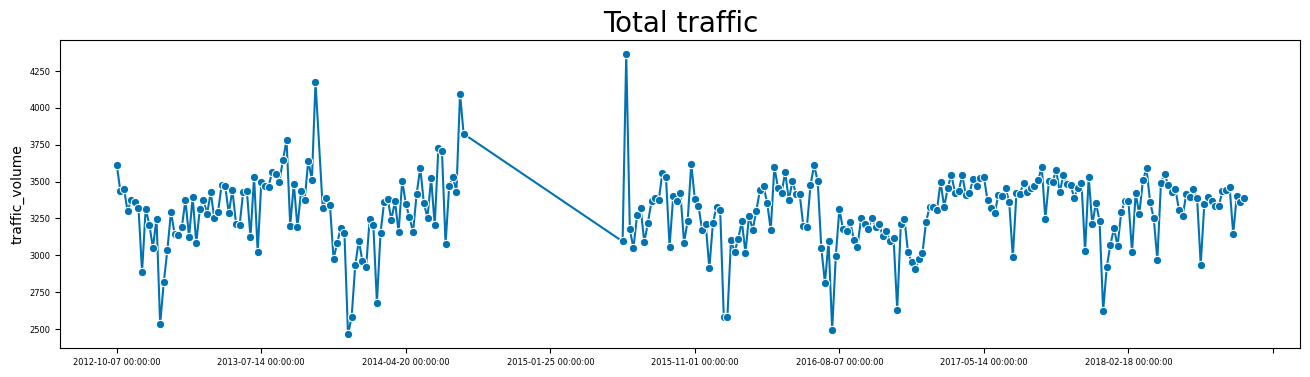

In [7]:
from sktime.utils.plotting import plot_series

plt.figure(figsize=(15, 6))
y = df.set_index('date_time')['traffic_volume'].resample('W').mean()

plot_series(y)
plt.title('Total traffic', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 6)
plt.show()

Из графика видно, что нет данных за существенный период времени: за вторую половину 2014 и первое полугодие 2015. Придется для построения моделей использовать данные более поздних периодов, где нет таких разрывов в данных. Восстанавливать искусственно такой большой промежуток, мне кажется, нет смысла. Возьмем данные с 1 января 2016 года до 30 сентября 2018 года - итого будет 2 года и 9 месяцев. Пропуски данных после этой даты не столь масштабны, восстановим их как прелагается в задании с помощью метода интерполяции ffill по последующим значениям. 


Для этого создадим массим с часовыми интревалами и объединим его с нашим датасетом.

In [8]:
df_upd = df[df['date_time'] >= '2016-01-01 00:00:00']
df_upd.shape

(23084, 4)

In [9]:
#date range with HOUR frequency
date_range = pd.date_range(start = df_upd['date_time'].min(), end = df_upd['date_time'].max(),
                          freq = 'H')
dates = pd.DataFrame(date_range, columns = ['Date'])
dates['Date'] = pd.to_datetime(dates['Date'])
print(f'Total dates in timeperiod {len(dates)}')

df_merged = dates.merge(df_upd, left_on = 'Date', right_on = 'date_time', how = 'outer')

df_merged = df_merged[['Date', 'traffic_volume', 'holid_upd', 'temp']]
print(f'New dataframe length {df_merged.shape}')

Total dates in timeperiod 24096
New dataframe length (24096, 4)


In [10]:
df_fin = df_merged.interpolate(method = 'ffill')
df_fin.isnull().sum()

Date              0
traffic_volume    0
holid_upd         0
temp              0
dtype: int64

Посмотрим на недельную динамику на графике ниже:
<li> видны дневние и вечерние пики
<li> есть падение трафика в выходные    

<Figure size 1500x600 with 0 Axes>

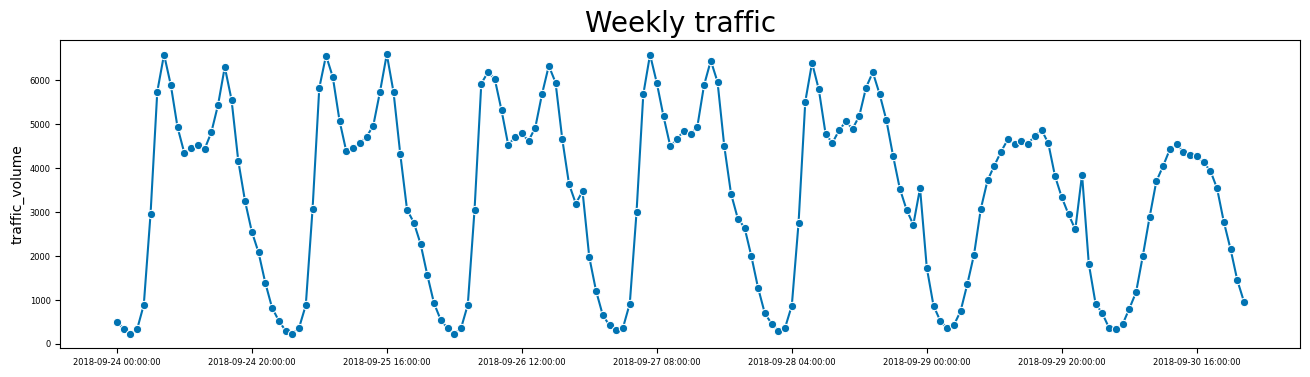

In [11]:
plt.figure(figsize=(15, 6))
y = df_fin.set_index('Date')['traffic_volume'].loc['2018-09-24 00:00:00':'2018-09-30 23:00:00']

plot_series(y)
plt.title('Weekly traffic', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 6)
plt.show()

In [12]:
df_fin = df_fin.sort_values(by = 'Date')
df_fin = df_fin.set_index('Date')
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24096 entries, 2016-01-01 00:00:00 to 2018-09-30 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_volume  24096 non-null  float64
 1   holid_upd       24096 non-null  float64
 2   temp            24096 non-null  float64
dtypes: float64(3)
memory usage: 753.0 KB


# Часть 2. Генерация фичей

Сгенерируем фичи 2-х типов - из частей даты (день недели, час, синус и косинус часа и тд.) и лагов (сдвинем даты в прошлое на 2 недели 10 раз)

In [13]:
def create_datetime_feature(df):
    df['weekday'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['hour_cos'] = np.cos(2 * np.pi * df["hour"].values / 23)
    df['hour_sin'] = np.sin(2 * np.pi * df["hour"].values / 23)
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

create_datetime_feature(df_fin)

,traffic_volume,holid_upd,temp,weekday,hour,hour_cos,hour_sin,month,year
Date,,,,,,,,,
2016-01-01 00:00:00,1513.0,1.0,265.94,4,0,1.000000,0.000000e+00,1,2016
2016-01-01 01:00:00,1550.0,0.0,266.00,4,1,0.962917,2.697968e-01,1,2016
2016-01-01 02:00:00,1550.0,0.0,266.00,4,2,0.854419,5.195840e-01,1,2016
2016-01-01 03:00:00,719.0,0.0,266.01,4,3,0.682553,7.308360e-01,1,2016
2016-01-01 04:00:00,533.0,0.0,264.80,4,4,0.460065,8.878852e-01,1,2016
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,0.0,283.45,6,19,0.460065,-8.878852e-01,9,2018
2018-09-30 20:00:00,2781.0,0.0,282.76,6,20,0.682553,-7.308360e-01,9,2018
2018-09-30 21:00:00,2159.0,0.0,282.73,6,21,0.854419,-5.195840e-01,9,2018


In [14]:
def create_lags(data):
    for step in range(14, 154, 14):
        target_map = data['traffic_volume'].to_dict()
        data[f'lag{step}'] = (data.index - pd.Timedelta(f'{step} days')).map(target_map)
    return data
create_lags(df_fin)  

,traffic_volume,holid_upd,temp,weekday,hour,hour_cos,hour_sin,month,year,lag14,lag28,lag42,lag56,lag70,lag84,lag98,lag112,lag126,lag140
Date,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1513.0,1.0,265.94,4,0,1.000000,0.000000e+00,1,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,1550.0,0.0,266.00,4,1,0.962917,2.697968e-01,1,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:00:00,1550.0,0.0,266.00,4,2,0.854419,5.195840e-01,1,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 03:00:00,719.0,0.0,266.01,4,3,0.682553,7.308360e-01,1,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 04:00:00,533.0,0.0,264.80,4,4,0.460065,8.878852e-01,1,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,0.0,283.45,6,19,0.460065,-8.878852e-01,9,2018,3400.0,3098.0,3792.0,3684.0,3661.0,3969.0,3438.0,3010.0,2830.0,3256.0
2018-09-30 20:00:00,2781.0,0.0,282.76,6,20,0.682553,-7.308360e-01,9,2018,3092.0,3115.0,3213.0,3316.0,3135.0,3571.0,3187.0,2979.0,2825.0,3049.0
2018-09-30 21:00:00,2159.0,0.0,282.73,6,21,0.854419,-5.195840e-01,9,2018,2623.0,2669.0,2682.0,2735.0,2803.0,2948.0,2556.0,2353.0,2656.0,2586.0


Разобъем финальный датасет на тестовую и учебную выборки

Train shape = (23760, 19)  Test shape = (336, 19)


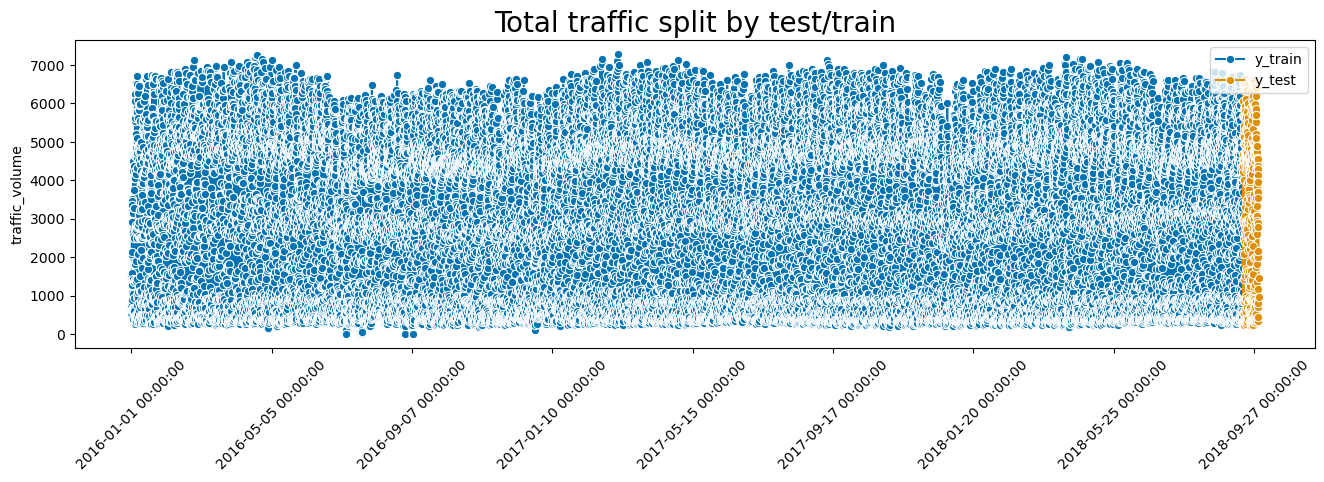

In [15]:
from sktime.forecasting.model_selection import temporal_train_test_split


y_train, y_test = temporal_train_test_split(df_fin, test_size=24*7*2)
plot_series(y_train['traffic_volume'], y_test['traffic_volume'], labels=["y_train", "y_test"])
plt.xticks(rotation = 45)
plt.title('Total traffic split by test/train', fontsize=20, color='black')
print(f'Train shape = {y_train.shape}  Test shape = {y_test.shape}')

# Часть 3. Постороение Baseline модели

Построим как предлагается в задании модель, которая посчитает среднее значение в зависимости от дня недели и часа и применем эти данные к тестовой выборке. Для этой модели посчитаем основые метрики для оценки качества регресcии и будем их дальше сравнивать с остальными моделями. Отобразим результаты на графике.


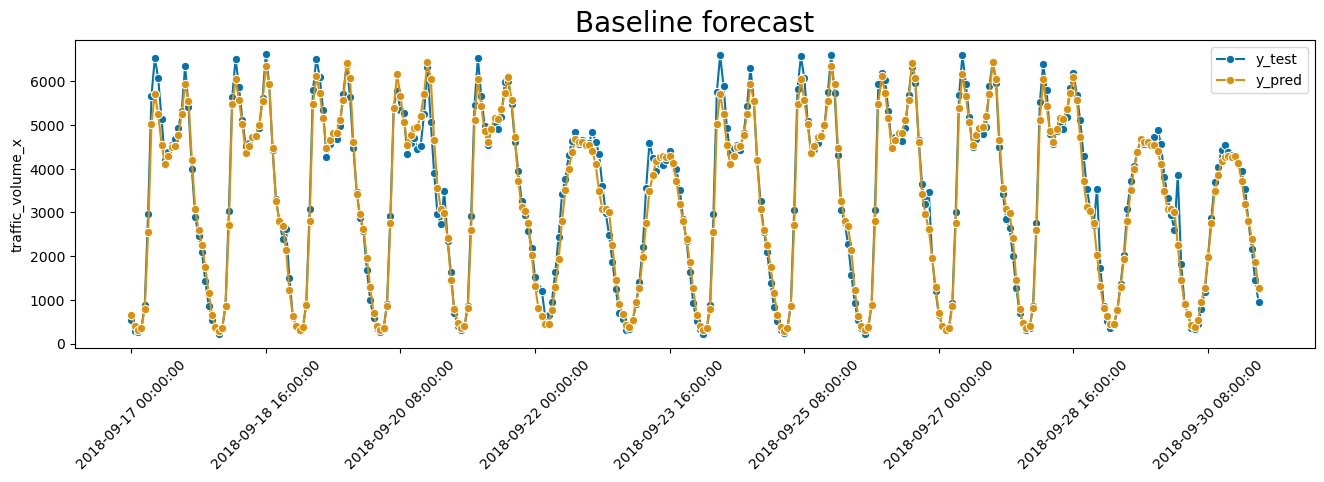

In [16]:
avg = y_train.groupby(['weekday', 'hour'])['traffic_volume'].mean()

test_baseline = y_test.copy()
test_baseline = test_baseline.join(avg, on = ['weekday', 'hour'], how = 'inner', 
                                   lsuffix = '_x', rsuffix = '_y')

plot_series(test_baseline['traffic_volume_x'].sort_index(), test_baseline['traffic_volume_y'].sort_index(), 
            labels=["y_test", "y_pred"])
plt.xticks(rotation = 45)
plt.title('Baseline forecast', fontsize=20, color='black')
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

scoring = pd.DataFrame()
new_row = {'Test':'Avg_baseline', 'RMSE':round(np.sqrt(mean_squared_error(test_baseline['traffic_volume_x'],test_baseline['traffic_volume_y'])),2),
           'MAE':round(mean_absolute_error(test_baseline['traffic_volume_x'],test_baseline['traffic_volume_y']),2),
           'MAPE': round(mean_absolute_percentage_error(test_baseline['traffic_volume_x'],test_baseline['traffic_volume_y']),4),
           'R2_score': round(r2_score(test_baseline['traffic_volume_x'],test_baseline['traffic_volume_y']),4)
           }
scoring = scoring.append(new_row, ignore_index = True)
scoring.set_index('Test').sort_values(by = 'R2_score', ascending=False)

,RMSE,MAE,MAPE,R2_score
Test,,,,
Avg_baseline,302.64,208.69,0.0881,0.9762


# Часть 4. Построение моделей

## 4.1 NaiveForecaster из библиотеки SkTime

https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html

Для построения прогноза используются очень простые модели: последнее значение, среднее и drift. Есть возможность учета сезонности. Укажем в параметрах стратегию last и установленную недельную сезонность. Предположим, что месячная сезонность незначительна.

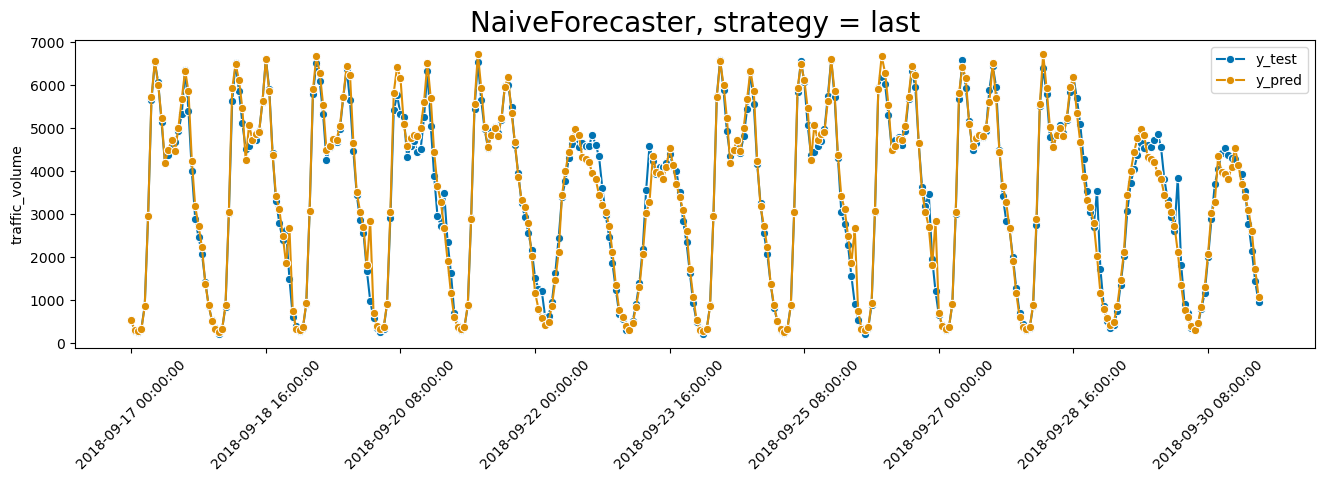

In [18]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last", sp=24*7)
forecaster.fit(y_train['traffic_volume'])

y_pred = forecaster.predict(ForecastingHorizon(y_test.index.to_period('H'), is_relative=False, freq = 'H'))

plot_series(y_test['traffic_volume'], y_pred.to_timestamp(), labels=["y_test", "y_pred"])
plt.xticks(rotation = 45)
plt.title('NaiveForecaster, strategy = last', fontsize=20, color='black')
plt.show()

In [19]:
new_row = {'Test':'Naive_S_Last', 'RMSE':round(np.sqrt(mean_squared_error(y_test['traffic_volume'],y_pred)),2),
           'MAE':round(mean_absolute_error(y_test['traffic_volume'],y_pred),2),
           'MAPE': round(mean_absolute_percentage_error(y_test['traffic_volume'],y_pred),4),
           'R2_score': round(r2_score(y_test['traffic_volume'],y_pred),4)
           }
scoring = scoring.append(new_row, ignore_index = True)
scoring.set_index('Test').sort_values(by = 'R2_score', ascending=False)

,RMSE,MAE,MAPE,R2_score
Test,,,,
Avg_baseline,302.64,208.69,0.0881,0.9762
Naive_S_Last,341.07,205.14,0.0899,0.9698


## 4.2 ExponentialSmoothing из библиотеки SkTime

https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.exp_smoothing.ExponentialSmoothing.html?highlight=ExponentialSmoothing

Экспоненциальное сглаживание Хольта-Уинтерса, которая учитывает экспоненциальный тренд и аддитивную сезонность. 

При запуске модели появляется предупреждение, но при этом модель дает неплохой прогноз. Я не придумала пока, как убрать эту ошибку.

C:\Users\Kate\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Kate\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


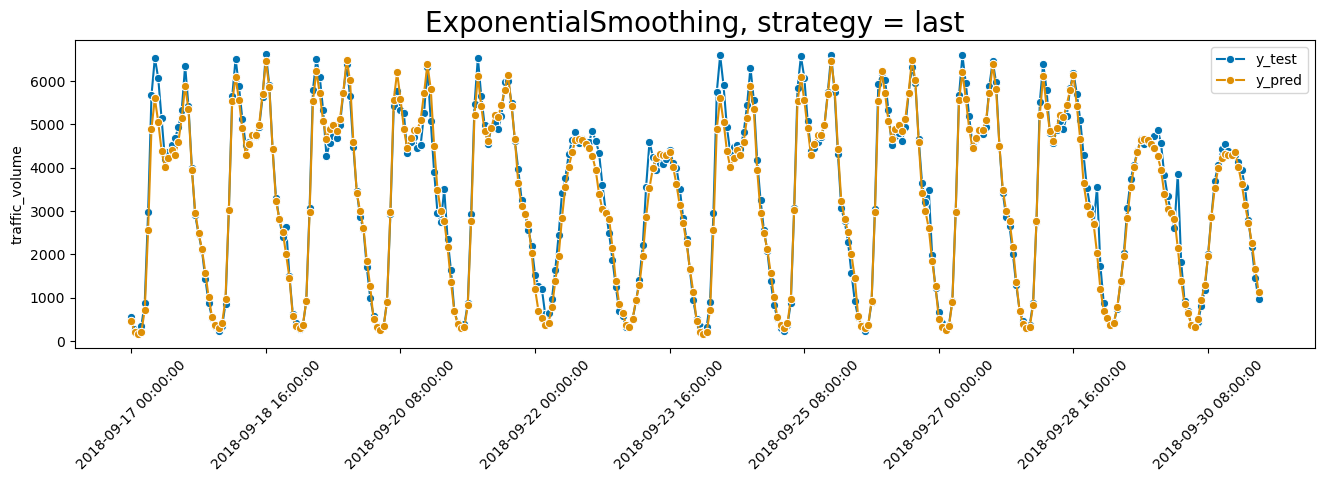

In [20]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(seasonal="add", sp=24*7)
forecaster.fit(y_train['traffic_volume'])

y_pred = forecaster.predict(ForecastingHorizon(y_test.index.to_period('H').to_timestamp(), is_relative=False, freq = 'H'))

plot_series(y_test['traffic_volume'], y_pred, labels=["y_test", "y_pred"])
plt.xticks(rotation = 45)
plt.title('ExponentialSmoothing, strategy = last', fontsize=20, color='black')
plt.show()

In [21]:
new_row = {'Test':'Exponent_smooth', 'RMSE':round(np.sqrt(mean_squared_error(y_test['traffic_volume'],y_pred)),2),
           'MAE':round(mean_absolute_error(y_test['traffic_volume'],y_pred),2),
           'MAPE': round(mean_absolute_percentage_error(y_test['traffic_volume'],y_pred),4),
           'R2_score': round(r2_score(y_test['traffic_volume'],y_pred),4)
           }
scoring = scoring.append(new_row, ignore_index = True)
scoring.set_index('Test').sort_values(by = 'R2_score', ascending=False)

,RMSE,MAE,MAPE,R2_score
Test,,,,
Avg_baseline,302.64,208.69,0.0881,0.9762
Exponent_smooth,309.00,205.76,0.0829,0.9752
Naive_S_Last,341.07,205.14,0.0899,0.9698


## 4.3 SARIMA

SARIMA авторегрессионная модель с сезонным компонентом. Для предсказания временного ряда с помощью этой модели нужно сделать несколько шагов:

1. проверить временной ряд на стационарность (постояноство мат. ожидания, дисперсии ряда и ковариации ряда). Для этого воспользуемся уже готовым тестом  Дики-Фуллера и kpss.
2. построить графики acf + pcf для проверки сезонности и регрессии

In [22]:
from statsmodels.tsa.stattools import adfuller, kpss

p_adf = adfuller(y_train['traffic_volume'], autolag = 'AIC', regression = 'c')
print('p-value Dickey-Fuller test: %f' % p_adf[1])

p_kpss = kpss(y_train['traffic_volume'], regression = 'c')
print('p-value KPSS test: %f' % p_kpss[1])

p-value Dickey-Fuller test: 0.000000
p-value KPSS test: 0.039315


Оба теста берут за основу разные гипотезы:
1. тест Дики-Фулера берет в качестве нулевой гипотезы, что ряд стационарен, т.о. значение p-value для этого теста подтверждает нулевую гипотезу о стационарности ряда. 
2. тест KPSS наоборот берет в качестве нулевой гипотезы использует утверждение, что ряд нестационарен. В нашем примере рузельтат теста не столько однозначен, так как получилось значение 4%, которое меньше 5%-го порога значимости, но больше 1%-го порога значимости. Возможны разные трактовки, для данного учебного примера примем порог значимости 1% и посчитаем, что ряд все-таки **стационарен**.

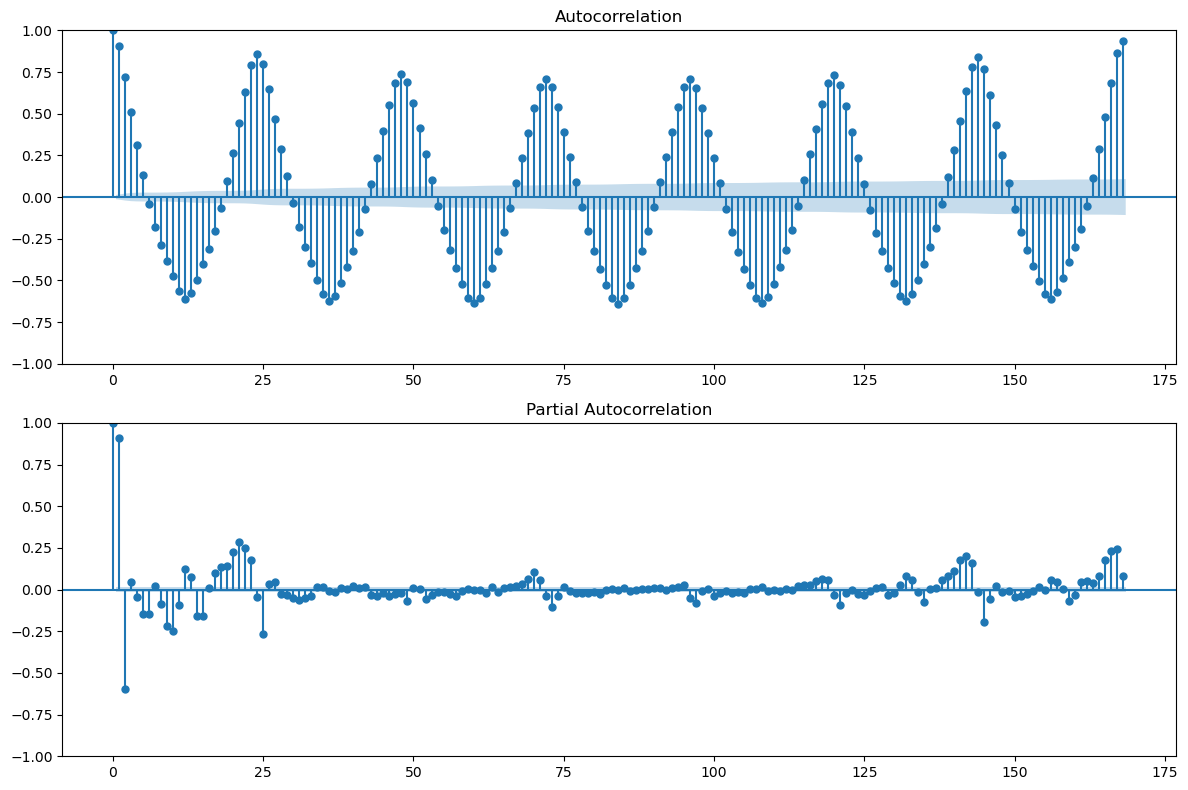

In [23]:
import statsmodels.api as sm

def plot_ts(df, lags):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(df, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(df, lags=lags, ax=ax2)
    plt.tight_layout()

plot_ts(y_train['traffic_volume'], lags = 24*7)

Оба графика показывают наличие автокорреляций, но не дают особо четкой картины какие параметры указывать для модели SARIMA, поэтому воспользуемся готовым решением "auto-arima" для подбора всех 6 параметров. Обработка довольно трудоемкая и будем использовать последние 3 недели для перебора параметров. 

In [24]:
%time
from pmdarima import auto_arima
stepwise_fit = auto_arima(y_train[-24*7*3:]['traffic_volume'], trace = True,
                          seasonal = True, m = 24*7,
                          start_P = 0, start_Q = 0,
                          max_P = 2, max_Q = 2,
                          
                          max_d = 2, max_D = 2,
                          alpha = 0.01,
                          
                          start_p = 1, start_q = 1,
                          max_p = 5, max_q = 7,
                          
                          test = 'kpss',
                          seasonal_test = 'ocsb',
                          
                          stepwise = True,
                          error_action = 'ignore',
                          n_fits = 30,
                          suppress_warnings=True,     
                          information_criterion='aic',
                          out_of_sample_size=7)

Wall time: 0 ns
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[168] intercept   : AIC=7911.050, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[168] intercept   : AIC=9085.324, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[168] intercept   : AIC=inf, Time=80.89 sec
 ARIMA(0,0,1)(0,0,1)[168] intercept   : AIC=inf, Time=73.10 sec
 ARIMA(0,0,0)(0,0,0)[168]             : AIC=9762.339, Time=0.01 sec
 ARIMA(1,0,1)(1,0,0)[168] intercept   : AIC=7651.240, Time=90.62 sec
 ARIMA(1,0,1)(2,0,0)[168] intercept   : AIC=7586.555, Time=254.70 sec
 ARIMA(1,0,1)(2,0,1)[168] intercept   : AIC=inf, Time=350.25 sec
 ARIMA(1,0,1)(1,0,1)[168] intercept   : AIC=inf, Time=105.38 sec
 ARIMA(0,0,1)(2,0,0)[168] intercept   : AIC=8409.804, Time=232.78 sec
 ARIMA(1,0,0)(2,0,0)[168] intercept   : AIC=inf, Time=225.55 sec
 ARIMA(2,0,1)(2,0,0)[168] intercept   : AIC=7632.942, Time=281.80 sec
 ARIMA(1,0,2)(2,0,0)[168] intercept   : AIC=7577.101, Time=302.38 sec
 ARIMA(1,0,2)(1,0,0)[168] intercept   : AIC=7628.081, Time=102.29

Итак, автоподбор предлагает использовать модель ***ARIMA(1,0,2)(2,0,0)[168] intercept***, где: 
<li> p – порядок авторегрессии (AR), который позволяет добавить предыдущие значения временного ряда. Этот параметр можно проиллюстрировать утверждением «завтра, вероятно, будет тепло, если в последние три дня было тепло».
<li> d – порядок интегрирования (I; т. е. порядок разностей исходного временного ряда). Он добавляет в модель понятия разности временных рядов (определяет количество прошлых временных точек, которые нужно вычесть из текущего значения). Этот параметр иллюстрирует такое утверждение: «завтра, вероятно, будет такая же температура, если разница в температуре за последние три дня была очень мала».
<li> q – порядок скользящего среднего (MA), который позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок
    
<li> P, D, Q - следуют тем же определениям, но применяются к сезонной составляющей временного ряда.

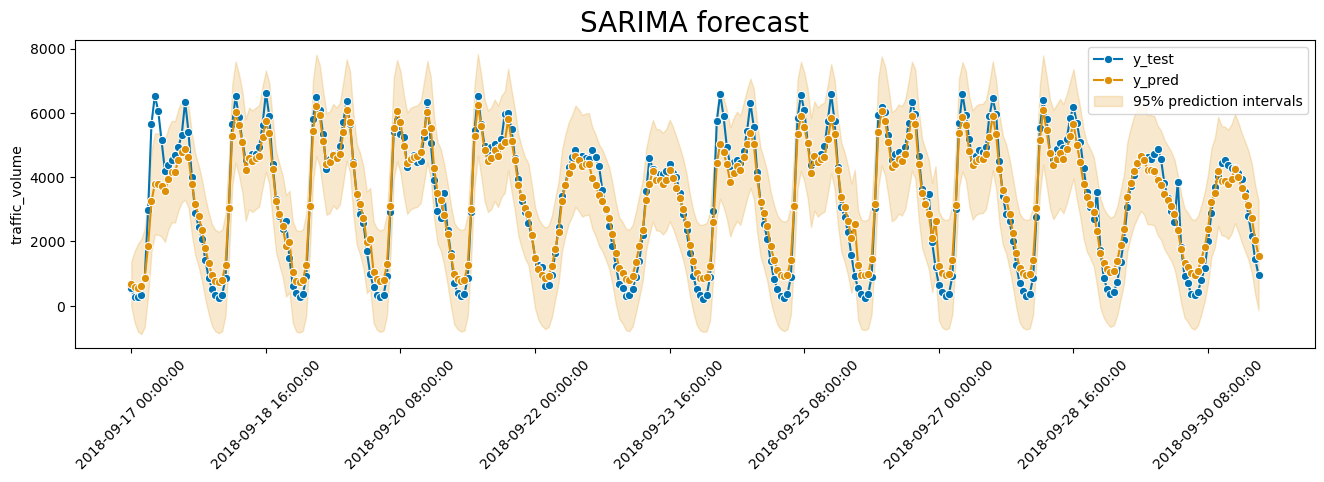

In [25]:
y_pred, pred_ci = stepwise_fit.predict(
    n_periods=24*7*2, 
    return_conf_int=True, 
    dynamic= True
    )

df_forecast = pd.DataFrame({'y_pred': y_pred, 'ci_lower': pred_ci[:,0], 'ci_upper': pred_ci[:,1]})
df_forecast.index = y_test.index

fig, ax = plot_series(y_test['traffic_volume'], df_forecast.y_pred, labels=["y_test", "y_pred"]);
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["ci_lower"],
    df_forecast["ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
             )
ax.legend(loc='best')
plt.title('SARIMA forecast', fontsize=20, color='black')
plt.xticks(rotation = 45)
plt.show()

In [26]:
new_row = {'Test':'SARIMA', 'RMSE':round(np.sqrt(mean_squared_error(y_test['traffic_volume'],df_forecast.y_pred)),2),
           'MAE':round(mean_absolute_error(y_test['traffic_volume'],df_forecast.y_pred),2),
           'MAPE': round(mean_absolute_percentage_error(y_test['traffic_volume'],df_forecast.y_pred),4),
           'R2_score': round(r2_score(y_test['traffic_volume'],df_forecast.y_pred),4)
           }
scoring = scoring.append(new_row, ignore_index = True)
scoring.set_index('Test').sort_values(by = 'R2_score', ascending=False)

,RMSE,MAE,MAPE,R2_score
Test,,,,
Avg_baseline,302.64,208.69,0.0881,0.9762
Exponent_smooth,309.00,205.76,0.0829,0.9752
Naive_S_Last,341.07,205.14,0.0899,0.9698
SARIMA,521.06,394.45,0.3355,0.9295


## 4.4 XGB

Воспользуемся XGB для регрессии, используя мин набор сгенерированных фичей из даты.

In [27]:
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

features = ['holid_upd', 'temp', 'weekday', 'hour', 'month', 'year']
target = ['traffic_volume']

X_train = y_train[features]
y_train1 = y_train[target]

X_test = y_test[features]
y_test1 = y_test[target]


scaler_xgb = StandardScaler()
X_train = scaler_xgb.fit_transform(X_train)
X_test = scaler_xgb.transform(X_test)

model_xgb = xgb.XGBRegressor(n_estimators = 500, learning_rate = 0.01)
model_xgb.fit(X_train, y_train1)
y_pred = model_xgb.predict(X_test)

new_row = {'Test':'XGB', 'RMSE':round(np.sqrt(mean_squared_error(y_test1.values, y_pred)),2),
           'MAE':round(mean_absolute_error(y_test1.values, y_pred),2),
           'MAPE': round(mean_absolute_percentage_error(y_test1.values, y_pred),4),
           'R2_score': round(r2_score(y_test1.values, y_pred),4)
           }
scoring = scoring.append(new_row, ignore_index = True)
scoring.set_index('Test').sort_values(by = 'R2_score', ascending=False)

,RMSE,MAE,MAPE,R2_score
Test,,,,
XGB,298.51,198.66,0.0816,0.9769
Avg_baseline,302.64,208.69,0.0881,0.9762
Exponent_smooth,309.00,205.76,0.0829,0.9752
Naive_S_Last,341.07,205.14,0.0899,0.9698
SARIMA,521.06,394.45,0.3355,0.9295


<Figure size 1500x800 with 0 Axes>

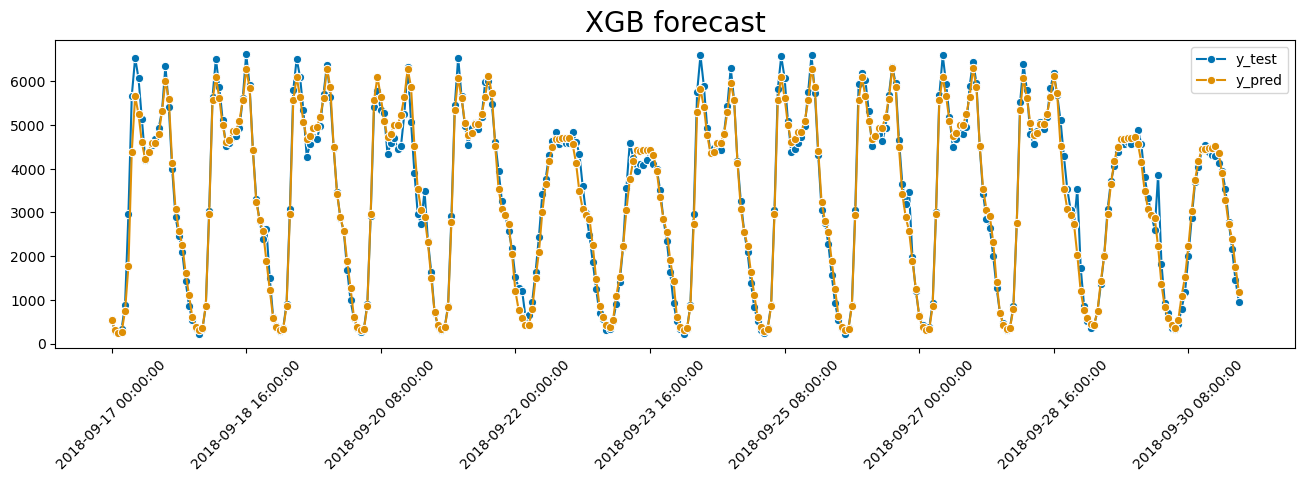

In [28]:
plt.figure(figsize = (15,8))
plot_series(y_test1, pd.DataFrame(y_pred, index = y_test.index), labels=["y_test", "y_pred"])

plt.legend(loc = 'best')
plt.xticks(rotation = 45)
plt.title('XGB forecast', fontsize=20, color='black')
plt.show()

## 4.5 LGBM
Воспользуемся LGBM для регрессии, используя весь набор сгенерированных фичей, включая лаги

In [29]:
from lightgbm import LGBMRegressor

X_train = y_train.drop('traffic_volume', axis = 1)
y_train1 = y_train['traffic_volume']

X_test = y_test.drop('traffic_volume', axis = 1)
y_test1 = y_test['traffic_volume']


scaler_lgbm = StandardScaler()
X_train = scaler_lgbm.fit_transform(X_train)
X_test = scaler_lgbm.transform(X_test)

model_lgbm = LGBMRegressor()
model_lgbm.fit(X_train, y_train1)
y_pred = model_lgbm.predict(X_test)

new_row = {'Test':'LGBM', 'RMSE':round(np.sqrt(mean_squared_error(y_test1.values, y_pred)),2),
           'MAE':round(mean_absolute_error(y_test1.values, y_pred),2),
           'MAPE': round(mean_absolute_percentage_error(y_test1.values, y_pred),4),
           'R2_score': round(r2_score(y_test1.values, y_pred),4)
           }
scoring = scoring.append(new_row, ignore_index = True)
scoring.set_index('Test').sort_values(by = 'R2_score', ascending=False)

,RMSE,MAE,MAPE,R2_score
Test,,,,
LGBM,279.66,181.51,0.0813,0.9797
XGB,298.51,198.66,0.0816,0.9769
Avg_baseline,302.64,208.69,0.0881,0.9762
Exponent_smooth,309.00,205.76,0.0829,0.9752
Naive_S_Last,341.07,205.14,0.0899,0.9698
SARIMA,521.06,394.45,0.3355,0.9295


<Figure size 1500x800 with 0 Axes>

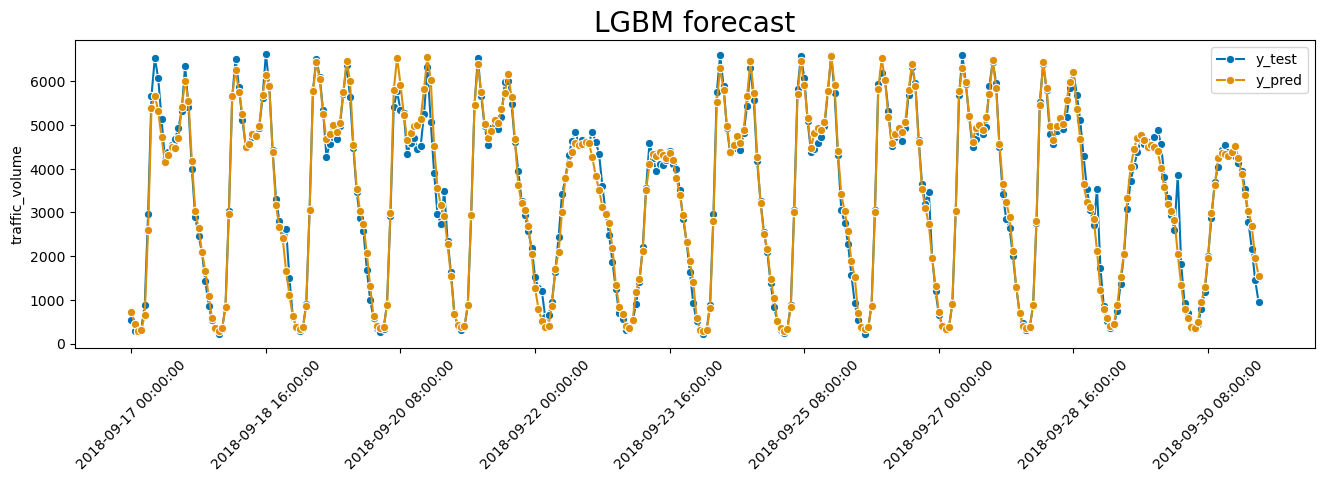

In [30]:
plt.figure(figsize = (15,8))
plot_series(y_test1, pd.DataFrame(y_pred, index = y_test.index), labels=["y_test", "y_pred"])

plt.legend(loc = 'best')
plt.xticks(rotation = 45)
plt.title('LGBM forecast', fontsize=20, color='black')
plt.show()

## 4.5 Prophet

https://facebook.github.io/prophet/docs/quick_start.html
Посмотрим, как будет работать уже готовая библиотека Prophet для предсказания по временным рядам. 

In [31]:
from prophet import Prophet

train_prophet = y_train['traffic_volume'].reset_index()\
                  .rename(columns = {'index':'ds',
                                    'traffic_volume':'y'})

model = Prophet()
model.fit(train_prophet)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [32]:
test_prophet = y_test['traffic_volume'].reset_index()\
                  .rename(columns = {'index':'ds',
                                    'traffic_volume':'y'})
pred = model.predict(test_prophet)
pred.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-09-17 00:00:00,3393.510279,-180.657922,2111.646443,3393.510279,3393.510279,-2420.468746,-2420.468746,-2420.468746,-2135.164304,...,-322.071594,-322.071594,-322.071594,36.767152,36.767152,36.767152,0.0,0.0,0.0,973.041533
1,2018-09-17 01:00:00,3393.542944,-693.308055,1474.171609,3393.542944,3393.542944,-3057.428216,-3057.428216,-3057.428216,-2805.260331,...,-289.444198,-289.444198,-289.444198,37.276313,37.276313,37.276313,0.0,0.0,0.0,336.114728
2,2018-09-17 02:00:00,3393.575609,-1154.706972,1073.689403,3393.575609,3393.575609,-3472.273133,-3472.273133,-3472.273133,-3252.742892,...,-257.316062,-257.316062,-257.316062,37.785822,37.785822,37.785822,0.0,0.0,0.0,-78.697524
3,2018-09-17 03:00:00,3393.608273,-940.897563,1206.434896,3393.608273,3393.608273,-3286.373503,-3286.373503,-3286.373503,-3098.836208,...,-225.832954,-225.832954,-225.832954,38.295659,38.295659,38.295659,0.0,0.0,0.0,107.234770
4,2018-09-17 04:00:00,3393.640938,-81.363710,2142.136868,3393.640938,3393.640938,-2378.540824,-2378.540824,-2378.540824,-2222.217937,...,-195.128694,-195.128694,-195.128694,38.805806,38.805806,38.805806,0.0,0.0,0.0,1015.100114


<Figure size 1500x800 with 0 Axes>

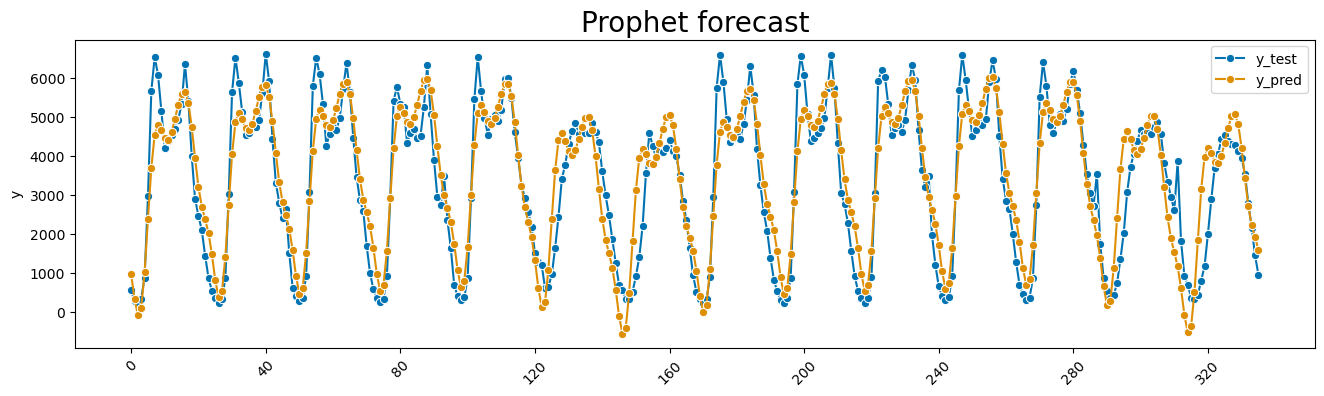

In [33]:
plt.figure(figsize = (15,8))
plot_series(test_prophet['y'], pred['yhat'], labels=["y_test", "y_pred"])
plt.legend(loc = 'best')
plt.xticks(rotation = 45)
plt.title('Prophet forecast', fontsize=20, color='black')
plt.show()

In [34]:
new_row = {'Test':'Prophet', 'RMSE':round(np.sqrt(mean_squared_error(test_prophet['y'], pred['yhat'])),2),
           'MAE':round(mean_absolute_error(test_prophet['y'], pred['yhat']),2),
           'MAPE': round(mean_absolute_percentage_error(test_prophet['y'], pred['yhat']),4),
           'R2_score': round(r2_score(test_prophet['y'], pred['yhat']),4)
           }
scoring = scoring.append(new_row, ignore_index = True)
scoring.set_index('Test').sort_values(by = 'R2_score', ascending=False)

,RMSE,MAE,MAPE,R2_score
Test,,,,
LGBM,279.66,181.51,0.0813,0.9797
XGB,298.51,198.66,0.0816,0.9769
Avg_baseline,302.64,208.69,0.0881,0.9762
Exponent_smooth,309.00,205.76,0.0829,0.9752
Naive_S_Last,341.07,205.14,0.0899,0.9698
SARIMA,521.06,394.45,0.3355,0.9295
Prophet,814.40,621.69,0.4192,0.8278


Итак, лучшая модель - это LGBM со всеми сгенерированными фичами. Будем ее использовать для последней части задания для генерации предсказания на 2 недели за пределами исторического интервала. Также воспользуемся встроенными возможностями этой билиотеки для оценки доверительного интервала для этих предсказаний.


# Часть 5. Предсказание на будущие даты

Для начала построим интервал в 2 недели от последней даты в нашем датасете, введм для него отдельный маркер "isFuture" и объединим его с нашим основным датасетом для генерации признаков. Предположим, что не эти 2 недели нет праздников.

In [35]:
future_range = pd.date_range(start = '2018-10-01 00:00:00', periods = 24*7*2,
                          freq = 'H')
future_df = pd.DataFrame(index = future_range)
future_df['isFuture'] = True
df_fin['isFuture'] = False
df_fin_future = pd.concat([df_fin, future_df])

df_fin_future = create_datetime_feature(df_fin_future)
df_fin_future = create_lags(df_fin_future)

df_fin_future['holid_upd'] = 0
df_future_toforecast = df_fin_future[df_fin_future['isFuture'] == True]

Итак, мы получили датасет для будущих дат, но нам в нем не хватает температуры как фичи. Как предлагалось в задании, предскажем ее отдельно при помощи уже подготовленных данных и добавим полученные значения в датасет для будущего.

In [36]:
X_train_temp = y_train.drop(['traffic_volume', 'temp'], axis = 1)
y_train_temp = y_train['temp']

scaler = StandardScaler()
X_train_temp = scaler.fit_transform(X_train_temp)
model_temp = LGBMRegressor()
model_temp.fit(X_train_temp, y_train_temp)

X_test_temp = df_future_toforecast.drop(['traffic_volume', 'temp', 'isFuture'], axis = 1)
temp_pred = model_temp.predict(X_test_temp)

df_future_toforecast['temp'] = temp_pred
df_future_toforecast = df_future_toforecast.drop(['traffic_volume','isFuture'], axis = 1)
df_future_toforecast.head(5)

,holid_upd,temp,weekday,hour,hour_cos,hour_sin,month,year,lag14,lag28,lag42,lag56,lag70,lag84,lag98,lag112,lag126,lag140
2018-10-01 00:00:00,0,265.988018,0,0,1.000000,0.000000,10,2018,550.0,962.0,922.0,703.0,714.0,676.0,652.0,642.0,1088.0,598.0
2018-10-01 01:00:00,0,266.114231,0,1,0.962917,0.269797,10,2018,280.0,694.0,473.0,421.0,402.0,423.0,422.0,396.0,559.0,366.0
2018-10-01 02:00:00,0,264.304396,0,2,0.854419,0.519584,10,2018,260.0,421.0,346.0,327.0,354.0,320.0,331.0,291.0,440.0,243.0
2018-10-01 03:00:00,0,264.304396,0,3,0.682553,0.730836,10,2018,344.0,310.0,369.0,375.0,355.0,348.0,406.0,310.0,332.0,308.0
2018-10-01 04:00:00,0,263.978226,0,4,0.460065,0.887885,10,2018,880.0,325.0,941.0,890.0,957.0,903.0,902.0,873.0,314.0,875.0


Воспользуемся ранее подготовленной моделью для генерации предсказания. Также в библиотеке есть возможность обучать модель и делать предсказания в виде интервала возможных значений с опредленной точностью, так как называемая quantile regression. В итоге мы получаем интервал, который может являться доверительным для нашего точечного предсказания.

In [37]:
X_pred = scaler_lgbm.transform(df_future_toforecast)

all_models = {}
for alpha in [0.05, 0.95]:
    lgbm = LGBMRegressor(objective="quantile", alpha=alpha, metric = "quantile")
    all_models["q %1.2f" % alpha] = lgbm.fit(X_train, y_train1)
y_lower = all_models["q 0.05"].predict(X_pred)
y_upper = all_models["q 0.95"].predict(X_pred)


df_future_toforecast['LGB'] = model_lgbm.predict(X_pred)

<Figure size 1500x800 with 0 Axes>

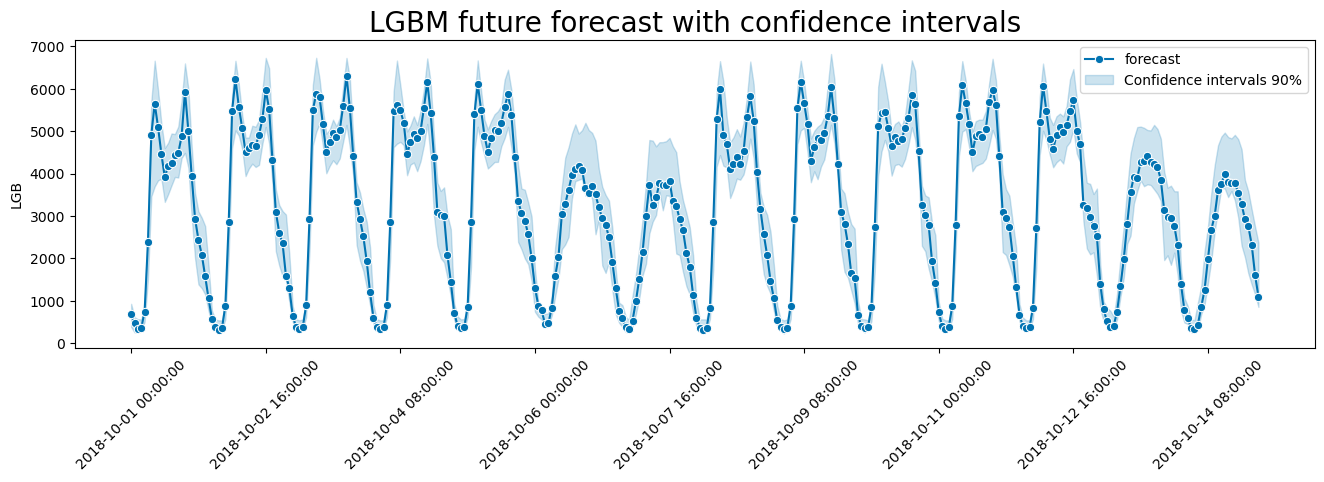

In [38]:
plt.figure(figsize = (15,8))
fig, ax = plot_series( 
            df_future_toforecast['LGB'], 
            labels=["forecast"], 
          )
ax.fill_between(ax.get_lines()[-1].get_xdata(),

                y1 = y_lower,
                y2 = y_upper,
                alpha=0.2,
                color=ax.get_lines()[-1].get_c(),
                label=f"Confidence intervals 90%"
               )


ax.legend(loc = 'best')
plt.title('LGBM future forecast with confidence intervals', fontsize=20, color='black')
plt.xticks(rotation = 45)
plt.show()

# Финальные выводы:

Интересно, что классические методы машинного обучения для предсказания справились лучше всех и приемлимым доверительным интервалом, но для генерации предсказаний за пределами изначального интервала, нужно иметь возможности сгенерировать фичи. Удобнее всего генерировать данные в специальных пакетах типа SARIMA или библиотеки Sktime, но там у меня получились метрики ниже baseline. Думаю, я не совсем корректно подобрала параметры.
